In [306]:
import numpy as np
from scipy.optimize import leastsq, fsolve,newton, brentq
from matplotlib import pyplot as plt


In [397]:
def L0(X):
    return np.exp(-X/2)

def L1(X):
    return L0(X) * (1 - X)

def model(t,coeffs,K,theta):
    res = coeffs[0] + coeffs[1] * L0(t[:,0]/K) + coeffs[2] * L1(t[:,0]/K) + coeffs[3] * L0(t[:,0]/K * t[:,1]/theta)
    
    return res
    
def residuals(coeffs, y, t,K,theta):
    return y - model(t, coeffs,K,theta)

def sol_lineaire(t,coeffs,K,theta):
    b = 1+coeffs[1]/(2*K) + coeffs[2]/(2*K) + coeffs[3]/(2*K)*np.exp(t/theta)
    a = coeffs[2]/(2*K)
    c = (coeffs[0] - K)

    return (-(b) + np.sqrt(np.square(b) - 4*a*c))/2*a



In [172]:
def integral(A=None,dF=None,F=None,axis = 0,trapez = False,cumulative = False):
    '''
    Turns an array A of length N (the function values in N points)
    and an array dF of length N-1 (the masses of the N-1 intervals)
    into an array of length N (the integral \int A dF at N points, with first entry 0)
    
    :param A: Integrand (optional, default ones, length N)
    :param dF: Integrator (optional, default ones, length N-1)
    :param F: Alternative to dF (optional, length N)
    :param trapez: Use trapezoidal rule (else left point)
    '''
    ndim = max(v.ndim for v in (A,dF,F) if v is not None)
    def broadcast(x):
        new_shape = [1]*ndim
        new_shape[axis] = -1
        return np.reshape(x,new_shape)
    if F is not None:
        assert(dF is None)
        if F.ndim<ndim:
            F = broadcast(F)
        N = F.shape[axis]
        dF = F.take(indices = range(1,N),axis = axis)-F.take(indices = range(N-1),axis = axis)
    elif dF is not None:
        if dF.ndim<ndim:
            dF = broadcast(dF)
        N = dF.shape[axis]+1
    else:
        if A.ndim<ndim:
            A = broadcast(A)
        N = A.shape[axis]
    if A is not None:
        if trapez:
            midA = (A.take(indices = range(1,N),axis = axis)+A.take(indices = range(N-1),axis = axis))/2
        else:
            if axis:
                midA = A.take(indices=range(N-1),axis=axis)
            else:
                midA = A[:-1]
        if dF is not None:
            dY = midA*dF
        else:
            dY = midA
    else:
        dY = dF
    pad_shape = list(dY.shape)
    pad_shape[axis] = 1
    pad = np.zeros(pad_shape)
    if cumulative:
        return np.concatenate((pad,np.cumsum(dY,axis = axis)),axis = axis)
    else:
        return np.sum(dY,axis = axis)
def heston(times,mu,rho,kappa,theta,xi,S0,nu0,d,M,nu_1d=True, random=np.random):
    '''
    Return M Euler-Maruyama sample paths with N time steps of (S_t,v_t), where
        (S_t,v_t) follows the Heston model of mathematical finance. 
    Currently requires times to be uniform
    :rtype: M x N x d array
    '''
    d_nu = 1 if nu_1d else d
    N = len(times)
    nu = np.zeros((M,N,d_nu))
    S = np.zeros((M,N,d))
    nu[:,0,:] = nu0
    S[:,0,:] = S0
    if 2*kappa*theta<=xi**2:
        raise ValueError('Feller condition not satisfied')
    test = np.std(np.diff(times.flatten())) 
    if test>1e-12:
        raise ValueError
    dt = times[1]-times[0]
    if d == 1:
        if np.array(rho).size ==1:
            rho = np.array([[1,rho],[rho,1]])
    chol = np.linalg.cholesky(rho)
    dW = np.sqrt(dt)*np.einsum('ij,...j',chol,random.normal(size=(M,N-1,d+d_nu)))
    for i in range(1,N):
        nu[:,i,:] = np.abs(nu[:,i-1,:] + kappa*(theta-nu[:,i-1,:])*dt+xi*np.sqrt(nu[:,i-1,:])*dW[:,i-1,d:])
    S = S0*np.exp(integral(np.sqrt(nu),dF = dW[:,:,:d],axis=1,cumulative = True)+integral(mu - 0.5*nu,F = times,axis=1,trapez=False,cumulative = True))
    return np.concatenate((S,nu),axis=-1)
    

In [173]:
def LSM(K,r,mu,rho,kappa,theta,xi,S0,nu0,d,N = 100, paths = 100):
        dt = 1 / (N - 1)  # time interval
        df = np.exp(-r * dt)  # discount factor per time time interval


        X0 = np.zeros((paths, 1))
        hes = heston(np.linspace(0,1,N),mu,rho,kappa,theta,xi,S0,nu0,d,paths,nu_1d=True, random=np.random)
        S = S0 * np.exp(hes)

        H = np.maximum(S - K, 0)  # intrinsic values for put option
        V = np.zeros_like(H[:,:,0])  # value matrix
        V[:, -1] = H[:, -1,0]
        def residuals(coeffs, y, t,K,theta):
            return y - model(t, coeffs,K,theta)
        # Valuation by LS Method
        for t in range(N - 2, 0, -1):
            good_paths = H[:, t] > 0

            x0 = [1,1,1,1]

            #print(residuals(x0,V[good_paths[:,0],t+1] * df, hes[t],K,theta))
            x, flag = leastsq(residuals, x0, args=(V[good_paths[:,0],t+1] * df, hes[t],K,theta))
            #S = np.array([hes[0,:,0]/self.K,hes[0,:,0]/self.K,hes[0,:,0]/self.K * hes[0,:,1]/self.theta])
            #rg = np.polyfit(S[good_paths, t,0], V[good_paths, t + 1,:] * df, order)  # polynomial regression
            C = np.polyval(x, hes[t])  # evaluation of regression

            exercise = np.zeros(len(good_paths), dtype=bool)
            print(H[t,good_paths].shape)
            exercise[good_paths] = H[t,good_paths] > C

            V[exercise, t] = H[exercise, t]
            V[exercise, t + 1:] = 0
            discount_path = (V[:, t] == 0)
            V[discount_path, t] = V[discount_path, t + 1] * df

        V0 = np.mean(V[:, 1]) * df  #
        return V0

In [174]:
res = LSM(K=1, r=0.05, mu=0.5, rho=-0.7, kappa=1, theta=1, xi=1, S0=1, nu0=1, d=1)

(200,)


ValueError: operands could not be broadcast together with shapes (200,) (100,2) 

In [419]:
def LSM(K,r,mu,rho,kappa,theta,xi,S0,nu0,d,N = 10, paths = 1000):
        hes = heston(np.linspace(0,.25,N),mu,rho,kappa,theta,xi,S0,nu0,d,paths,nu_1d=True, random=np.random)
        cashflow = np.maximum(K - hes[:,-1,0] , 0)  # intrinsic values for put option
        cashflow = np.concatenate((np.expand_dims(cashflow, axis=1),np.expand_dims(hes[:,-1,1],axis=1)),axis=1)
        # Valuation by LS Method
        t = np.linspace(0,.25,N)
        V0 = 0
        Vmax = 0.7
        nv = 10
        scale = np.linspace(1,10,10)
        borne = scale * (Vmax - V0)/nv + V0
        boundaries = []
        for i in range(N - 2, 0, -1):
            df = np.exp(-r*(t[i+1] - t[i]))
            cashflow = cashflow * df
            x0 = [2,2,2,2]
            x = hes[:,i]
            print(hes[:,i].shape)
            exercise = np.maximum(K - x[:,0],0)
            itm = exercise > 0
            print(itm.shape)
            print('ok')
            coeffs, flag = leastsq(residuals, x0, args=(cashflow[itm][:,0],x[itm],K,theta))
            print(coeffs)
            continuation = model(x,coeffs,K,theta)
            #ex_idx = itm & (exercise > continuation)
            # update cashflows with early exercises
            #cashflow[ex_idx,0] = exercise[ex_idx]
            def f(unknown,vol,coeffs):
                return K  - unknown - coeffs[0] - coeffs[1] * L0(unknown/K) - coeffs[2] * L1(unknown/K)- coeffs[3] * L0((unknown/K) * (vol/theta))
            #solve
            #fsolve(f,cashflow[:,1],args=(0.1))

            tri = [[],[],[],[],[],[],[],[],[],[]]

            for i in cashflow[:,1]:

                for j in range(len(borne)-1):
                    if borne[j] <= i <= borne[j+1]:

                        tri[j].append(i)
            pred = [[],[],[],[],[],[],[],[],[],[]]
            for i in range(len(tri)):
                #print(tri[i])
                for j in tri[i]:

                    pred[i].append(newton(f,0,args=(j,coeffs,),maxiter=1000)* np.exp(-r * (t[-1] - t[0])))



            print(np.max(pred))
            print(cashflow.mean(axis=0) * np.exp(-r * (t[-1] - t[0])))
            
        return cashflow.mean(axis=0) * np.exp(-r * (t[-1] - t[0]))
            

In [422]:
LSM(K=10, r=0.1, mu=0.1, rho=0.1, kappa=5, theta=0.16, xi=0.9, S0=12, nu0=0.0625, d=1)

(1000, 2)
(1000,)
ok
[ 1.91838734e+02 -3.15656700e+02  1.63251369e+02 -2.51323689e-01]
[8.019648364252081]
[0.07130352 0.13216685]
(1000, 2)
(1000,)
ok
[ 46.99610812 -75.70168916  44.68533828  -1.07457599]
[5.0380227443903784]
[0.07110573 0.13180023]
(1000, 2)
(1000,)
ok
[-81.19949016 134.8795484  -53.44615919  -0.65256224]
[9.221654926331727, 9.159719865553404, 9.201296882482612, 9.131201127441944, 9.053268142836927, 9.231075902926479, 8.93966219237404, 9.235892777704665, 9.125599763112154, 9.103127838419129, 9.295153717727484, 9.153660067451877, 9.054309667956499, 9.142125521438695, 9.02991477733192, 9.1677879984716, 9.181532470655027, 9.005936712903017, 9.009429867900677, 9.092159747502702, 8.944436319813743, 9.256034665246736, 9.051593440600831, 9.105084659167916, 9.018759721118808, 9.083189243791736, 9.288847631054486, 9.034383336032587, 9.14164689634198, 9.101658920861592, 9.119318521787283, 9.080841385195049, 9.16821028571941, 9.16760571469209, 9.142915479626621, 9.0050427419384

[5.570505574442117, 5.559049384189416, 5.568335968569807, 5.5698053992156416, 5.567296808405424, 5.564323216478772, 5.570825355208999, 5.559619677229118, 5.570987828904737, 5.567089671228362, 5.566248519969392, 5.572930667119259, 5.568117311527541, 5.5643642792800145, 5.567697911458066, 5.563392872835775, 5.5686253073513425, 5.569113542565936, 5.562418264681901, 5.562561480747681, 5.565832022644549, 5.559826521640709, 5.571659737165329, 5.564257113803181, 5.566322415363484, 5.562941927760048, 5.565488452910229, 5.5727287943806605, 5.563572321454332, 5.567680417567414, 5.566192967448105, 5.566856196376457, 5.5653980929249505, 5.5590543387486475, 5.568640395399799, 5.568618792752691, 5.5677267687837775, 5.5623815447031895, 5.559037976403717, 5.5596900537371745, 5.559965884285618, 5.572060931096471, 5.562444601522262, 5.5621529706978805, 5.572058659054519, 5.571912612453825, 5.5721650300385726, 5.561153115833492, 5.561329275103188, 5.567841060038782, 5.559826488990254, 5.573175942711347, 

TypeError: Improper input: N=4 must not exceed M=1

In [383]:
coeffs = [ 7.83829449, -12.77665732,  18.43279611,   0.09120715]
K = 10
theta = .16
def f(unknown,vol):
    return K - unknown - coeffs[0] - coeffs[1] * L0(unknown/K) - coeffs[2] * L1(unknown/K) - coeffs[3] * L0(unknown/K * vol/theta)

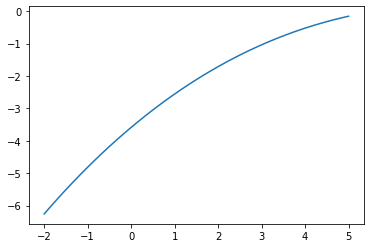

In [392]:
unknown = np.linspace(-2,5,1000)
plt.plot(unknown,f(unknown,0.))

In [59]:
a

[[0], [0, 6], [0], [0]]

In [60]:
a[1].append(5)

In [61]:
a

[[0], [0, 6, 5], [0], [0]]

In [62]:
a[0].append(3)

In [63]:
a

[[0, 3], [0, 6, 5], [0], [0]]